# Machine Problem 3: NumPy CNN

### Import Libraries

In [1]:
import numpy as np
import os
import time
from scipy import signal
from imageio import imread
from random import shuffle
from matplotlib import pyplot as plt

%matplotlib inline

### Preprocessing Functions

In [2]:
# load_images
    # Read in images and makes a list for each set in the form: [images, labels]
    # images: np array with dims [N x img_height x img width x num_channels]
    # labels: np array with dims [N x 1]. elephant = 0, lionfish = 1
    #
    # Returns:  train_set: The list [train_images, train_labels]
    #           val_set: The list [val_images, val_labels] 

def load_images():
    
    sets = ['train', 'val']
    
    data_sets = []
    for dset in sets:
        img_path = './bin_dataset/' + dset + '/ele'
        ele_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        img_path = './bin_dataset/' + dset + '/lio'
        lio_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        set_images = np.stack(ele_list + lio_list)
        N = set_images.shape[0]
        labels = np.ones((N,1))
        labels[0:int(N/2)] = 0
        data_sets.append([set_images, labels])

    train_set, val_set = data_sets

    print("Loaded", len(train_set[0]), "training images")
    print("Loaded", len(val_set[0]), "validation images")
    
    return train_set, val_set


# batchify
    # Inputs:    train_set: List containing images and labels
    #            batch size: The desired size of each batch
    #
    # Returns:   image_batches: A list of shuffled training image batches, each with size batch_size
    #            label_batches: A list of shuffled training label batches, each with size batch_size 

def batchify(train_set, batch_size):
    
    # YOUR CODE HERE
    data_size,_,_,_ = train_set[0].shape
    x = list(range(data_size))
    shuffle(x);
    k = 0
    image_batches = []
    label_batches = []
    for i in range(int(data_size/batch_size)):
        temp_train_list = []
        temp_label_list = []
        for j in range(batch_size):
            val = x[k]
            temp_train_list.append(np.array(train_set[0][val]))
            temp_label_list.append(np.array(train_set[1][val]))
            k += 1
        image_batches.append(np.array(temp_train_list))
        label_batches.append(np.array(temp_label_list))
    return image_batches, label_batches
# def batchify(train_set, batch_size):
    
#     # YOUR CODE HERE
#     # initialized two lists
#     image_batches = []
#     label_batches = []
    
#     shuffle_index = np.arange(len(train_set[0]))
#     shuffle(shuffle_index)
    
#     image_chunk = [None] * batch_size
#     label_chunk = [None] * batch_size
#     for c in range(0, len(shuffle_index), batch_size):
#         for i in range(batch_size):
#             image_chunk[i] = train_set[0][shuffle_index[c+i]]
#             label_chunk[i] = train_set[1][shuffle_index[c+i]]
#         image_batches.append(np.array(image_chunk))
#         label_batches.append(np.array(label_chunk))

#     return image_batches, label_batches



def normalization(train_set, val_set):
    new_train = train_set.astype(float)
    new_train /= 256.0
    new_val = val_set.astype(float)
    new_val /= 256.0
    return new_train, new_val;

### Network Functions

#### Activation Functions

In [3]:
# relu
    # Inputs:   x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:  out: Multi-dimensional array with same size of x 

def relu(x):
    
    # YOUR CODE HERE
    out = np.maximum(0,x);
    return out


# sigmoid
    # Inputs:    x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def sigmoid(x):
    
    # YOUR CODE HERE
    out = 1.0/(1.0+ np.exp(-x))
    return out


# unit_step
    # Inputs:    x: Multi-dimensional array with size N along the first axis 
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def unit_step(x):
    
    # YOUR CODE HERE
    out = np.heaviside(x,1);
    return out 
# relu
    # Inputs:   x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:  out: Multi-dimensional array with same size of x 

# def relu(x):
    
#     # YOUR CODE HERE
#     out = np.maximum(x, 0)
#     return out


# # sigmoid
#     # Inputs:    x: Multi-dimensional array with size N along the first axis
#     # 
#     # Returns:   out: Multi-dimensional array with same size of x 

# def sigmoid(x):
    
#     # YOUR CODE HERE
#     out = 1.0/(1 + np.exp(-x))
#     return out

# def d_sigmoid(x):
#     out = sigmoid(x) * (1-sigmoid(x))
#     return out

# # unit_step
#     # Inputs:    x: Multi-dimensional array with size N along the first axis 
#     # 
#     # Returns:   out: Multi-dimensional array with same size of x 

# def unit_step(x):
    
#     # YOUR CODE HERE
#     out = np.heaviside(x, 1)
#     return out 

#### Layer Functions

In [4]:
# convolve2D
    # Inputs:    X: [N x height x width x num_channels]
    #            filters: [num_filters x filter_height x filter_width x num_input_channels]
    # 
    # Returns:   Xc: output array by convoling X and filters. [N x output_height x output_width x num_filters]

def convolve2D(X0, filters):
   
    N, X0_len, _, num_ch = X0.shape
    num_out_ch, filter_len, _, _ = filters.shape
    F0_side = X0_len - filter_len + 1
    
    F0 = np.zeros((N, F0_side, F0_side, num_out_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                # YOUR CODE HERE
                F0[n,0:,0:,o_ch] += signal.convolve2d(X0[n,0:,0:,ch],filters[o_ch,0:,0:,ch],mode = "valid")
    return F0


# maxPool
    # Inputs:    R0: [N x height x width x num_channels]
    #            mp_len: size of max pool window, also the stride for this MP
    # 
    # Returns:   p_out: output of pooling R0. [N x output_height x output_width x num_channels]
    #            R0_mask: A binary mask with the same size as R0. Indicates which index was chosen to be the max
    #            for each max pool window. This will be used for backpropagation.

def maxPool(R0, mp_len):

    N, R0_len, _, num_ch = R0.shape
    p_out_len = int((R0_len-mp_len)/mp_len + 1)

    R0_mask = np.zeros(R0.shape)
    p_out = np.zeros((N, p_out_len, p_out_len, num_ch))
    
    for n in range(N):
        for ch in range(num_ch):
            for row in range(p_out_len): 
                for col in range(p_out_len):
                    # YOUR CODE HERE
                    u_row = row*mp_len
                    d_row = min(R0_len,(row+1)*mp_len)
                    l_col = col*mp_len
                    r_col = min(R0_len,(col+1)*mp_len)
                    temp_arr = R0[n,u_row:d_row,l_col:r_col,ch]
                    p_out[n,row,col,ch] = np.amax(temp_arr)
                    temp_index = np.argmax(temp_arr)
                    temp_r = temp_index//mp_len + u_row
                    temp_c = temp_index%mp_len + l_col
                    R0_mask[n,temp_r,temp_c,ch] = 1
    return p_out, R0_mask


# flatten
    #input:      X1'[N x height x width x num_channels]
    #
    #
    #Return:     X1 [N x (height x width x num_channels)]
def flatten(X1_p):
    N,h,w,ch = X1_p.shape
    X1 = X1_p.reshape((N,(h*w*ch)))
    return X1
    

# fc
    # Inputs:    X: [N x num_input_features]
    #            W: [num_input_features x num_fc_nodes]
    # 
    # Returns:   out: Linear combination of X and W. [N x num_fc_nodes]
    
def fc(X, W):
    
    # YOUR CODE HERE
    out = X@W
    return out

#### CNN Functions

In [5]:
# cnn_fwd
    # Inputs:    X0: batch of images. [N x img_height x img_width x num_channels]
    #            W0, W1, W2: Parameters of the CNN
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   sig: vector containing the output for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations that will be
    #            used in backpropagation
    
def cnn_fwd(X0, W0, W1, W2, mp_len):
    
    # F0 
    # YOUR CODE HERE
    F0 = convolve2D(X0,W0)
    R0 = relu(F0)
    # X1p 
    # YOUR CODE HERE
    X1p,R0_mask = maxPool(R0, mp_len)
    # X1 (flatten)
    # YOUR CODE HERE
    X1 = flatten(X1p)
    # FC Layers
    # YOUR CODE HERE
    F1 = fc(X1,W1)
    X2 = relu(F1)
    F2 = fc(X2,W2)
    sig = sigmoid(F2)
    # Output
    # YOUR CODE HERE
    
    # Save outputs of functions for backward pass
    cache = {
        "F0":F0,
        "R0":R0,
        "X1p":X1p,
        "R0m":R0_mask,
        "X1":X1,
        "F1":F1,
        "X2":X2,
        "F2":F2,
        "sig":sig
    }
    
    return sig, cache


# loss
    # Inputs:    sig: vector containing the CNN output for each sample. [N x 1]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    # 
    # Returns:   L: Loss/error criterion for the model. 

def loss(sig, Y):
    
    # YOUR CODE HERE
    # cross entropy
    L = 0.0
    N, _ = Y.shape
    for i in range(N):
        L -= Y[i]*np.log(sig[i]) + (1-Y[i])*np.log(1-sig[i])
    L /= N
    return L


### Backprop Functions

In [6]:
# convolve2DBwd
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            dL_dF0: Gradient at the output of the conv layer. 
    # 
    # Returns:   dL_dW0. gradient of loss L wrt W0. Same size as W0

def convolve2DBwd(X0, dL_dF0):
    
    N, X0_len, _, num_ch = X0.shape
    _, dL_dF0_len, _, num_out_ch  = dL_dF0.shape
    filter_len = X0_len - dL_dF0_len + 1
    
    dL_dW0 = np.zeros((num_out_ch, filter_len, filter_len, num_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                # YOUR CODE HERE 
                dL_dW0[o_ch,:,:,ch] += signal.convolve2d(X0[n,::-1,::-1,ch], dL_dF0[n,:,:,o_ch], mode="valid")
    return dL_dW0


# maxPoolBwd
    # Inputs:    dL_dX1p: Gradient at the output of the MaxPool layer
    #            R0_mask: A binary mask with the same size as R0. Defined in maxPool
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   dL_dR0: Gradient at the output of ReLu
    
def maxPoolBwd(dL_dX1p, R0_mask,  mp_len):
    
    N, H, W, C = R0_mask.shape
    N, dH, dW, C = dL_dX1p.shape
    
    dL_dR0 = np.zeros(R0_mask.shape)
    
    for n in range(N):
        for ch in range(C):
            for row in range(dH):
                for col in range(dW):
                    # YOUR CODE HERE
                    u_row = row*mp_len
                    d_row = (row+1)*mp_len
                    l_col = col*mp_len
                    r_col = (col+1)*mp_len
                    temp_arr = R0_mask[n,u_row:d_row,l_col:r_col,ch]
                    dL_dR0[n,u_row:d_row,l_col:r_col,ch] = dL_dX1p[n,row,col,ch]*temp_arr
    return dL_dR0



# def maxPoolBwd(dL_dX1p, R0_mask,  mp_len):
    
#     N, H, W, C = R0_mask.shape
#     N, dH, dW, C = dL_dX1p.shape
    
#     dL_dR0 = np.zeros(R0_mask.shape)
    
#     for n in range(N):
#         for ch in range(C):
#             for row in range(dH):
#                 for col in range(dW):
#                     # YOUR CODE HERE
#                     dL_dR0[n,row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len,ch] = dL_dX1p[n,row,col,ch]*R0_mask[n,row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len,ch]
#     return dL_dR0






def dL_dF2(Y, cache):
    N,_ = Y.shape
    sig = cache["sig"]
    ret = (sig - Y) / N
    return ret # N x 1



# dL_dW2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW2: Gradient of the Loss wrt W2
    
def dL_dW2(Y, cache):
   
    # YOUR CODE HERE
    X2 = cache["X2"]
    dL_F2 = dL_dF2(Y, cache)
    dL_dW2 = X2.T@dL_F2
    return dL_dW2 # 2 x 1


# dL_dW1
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            W2: Weight matrix for the second FC layer
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW1: Gradient of the Loss wrt W1
    
def dL_dW1(cache, dF1):
    X1 = cache["X1"]
    dL_dW1 = X1.T @ dF1
    # YOUR CODE HERE
    
    return dL_dW1 # 192 x 2

def dL_dX2(dF2, W2):
    return dF2@W2.T # N x 2

def dL_dF1(dX2,cache):
    F1 = cache["F1"]
    return dX2*unit_step(F1) # N x 2
def dL_dX1(dF1, W1):
    return dF1 @ W1.T

def flattenBwd(dX1, cache):
    X1p = cache["X1p"]
    N,h,w,ch = X1p.shape
    X1p_bwd = dX1.reshape((N,h,w,ch))
    return X1p_bwd # N x 8 x 8 x 3

def dL_dF0(dR0,cache):
    F0 = cache["F0"]
    return dR0*unit_step(F0) # n x 96 x 96 x 3
    
# dL_dW0
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    #            W1: Weight matrix for the first FC layer
    #            W2: Weight matrix for the second FC layer
    #            mp_len: the length of one side of the max pool window
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW0: Gradient of the Loss wrt W0

# def dL_dW0(X0, Y, W1, W2, mp_len, cache):
#     N, X1p_len, _, no_out_ch  = cache['X1p'].shape
#     F2 = cache['F2']
#     F1 = cache['F1']
#     R0m = cache['R0m']
#     F0 = cache['F0']
    
#     #dL_dF2
#     # YOUR CODE HERE
#     dL_F2 = dL_dF2(Y,cache)
#     dL_
#     #dL_dF1
#     # YOUR CODE HERE
    
#     #dL_dX1
#     # YOUR CODE HERE
    
#     # dL_dX1p (unflatten)
#     # YOUR CODE HERE
    
#     # dL_dR0 (unpool)
#     # YOUR CODE HERE
    
#     # dL_dF0 (relu_bwd)
#     # YOUR CODE HERE
    
#     # dL_dW0
#     # YOUR CODE HERE
    
#     return dL_dW0
def cnn_bwd(X0,Y,W1,W2,mp_len,cache):
    R0_mask = cache["R0m"]
    dF2 = dL_dF2(Y, cache)
    dW2 = dL_dW2(Y,cache)
    dX2 = dL_dX2(dF2, W2)
    dF1 = dL_dF1(dX2,cache)
    dW1 = dL_dW1(cache, dF1)
    dX1 = dL_dX1(dF1, W1)
    dX1p = flattenBwd(dX1, cache)
    dR0 = maxPoolBwd(dX1p, R0_mask,  mp_len)
    dF0 = dL_dF0(dR0,cache)
    dW0 = convolve2DBwd(X0, dF0)
    return dW0,dW1,dW2
        
def update(W0, W1, W2, dW0, dW1, dW2, lr):
    W0_p = W0 - lr*dW0
    W1_p = W1 - lr*dW1
    W2_p = W2 - lr*dW2
    return W0_p, W1_p, W2_p
    

### Training

#### Load Images

In [7]:
# Load images and scale them
# YOUR CODE HERE
train_set, val_set = load_images()
train_set[0], val_set[0] = normalization(train_set[0], val_set[0])
# image_batches, label_batches = batchify(train_set,16)

Loaded 2000 training images
Loaded 800 validation images


#### Config

In [8]:
# Hyperparameters
epochs = 20
lr = 0.1
image_size = 10
batch_size = 16
filter_len = 5
num_out_ch = 3
mp_len = 12
fc_nodes = 2
# Declare weights
# YOUR CODE HERE
W0 = np.random.normal(0,0.05,(num_out_ch,filter_len,filter_len,3))
W1 = np.random.normal(0,0.05,(192, fc_nodes))
W2 = np.random.normal(0, 0.05, (fc_nodes, 1))

In [9]:
accuracy = []
error = []
for i in range(epochs):
    
    # make set of batches
    # YOUR CODE HERE
    image_batches, label_batches = batchify(train_set, batch_size)
    num_batches = len(image_batches)
    
    # record the time for the execution
    start_time = time.time()
    for b_idx in range(num_batches):
        X = image_batches[b_idx]
        Y = label_batches[b_idx]
        
        # Forward pass
        # YOUR CODE HERE
        sig, cache = cnn_fwd(X, W0, W1, W2, mp_len)
        
        # Calculate gradients
        # YOUR CODE HERE
        dW0, dW1, dW2 = cnn_bwd(X, Y, W1, W2, mp_len, cache)
        
        # Update gradients
        # YOUR CODE HERE
        W0, W1, W2 = update(W0, W1, W2, dW0, dW1, dW2, lr)
        
    # calcuate the loss and accuracy in each epoch
    sig, _ = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
    train_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])
    accuracy.append(train_acc)
    err = loss(sig, val_set[1])
    error.append(err)
   #
    if (i % 5) == 0 and i > 4:
        lr *= 0.75

After epoch 1
train_loss: [0.71425516] train_acc: 0.50375
---total cost for this epoch is 33.12486481666565 seconds ---
current learning rate is: 0.1
After epoch 2
train_loss: [0.53120658] train_acc: 0.7525
---total cost for this epoch is 32.700456857681274 seconds ---
current learning rate is: 0.1
After epoch 3
train_loss: [0.31803687] train_acc: 0.86
---total cost for this epoch is 32.39314293861389 seconds ---
current learning rate is: 0.1
After epoch 4
train_loss: [0.54807283] train_acc: 0.6425
---total cost for this epoch is 32.54948401451111 seconds ---
current learning rate is: 0.1
After epoch 5
train_loss: [0.33883] train_acc: 0.85625
---total cost for this epoch is 32.32273507118225 seconds ---
current learning rate is: 0.1
After epoch 6
train_loss: [0.31233813] train_acc: 0.86375
---total cost for this epoch is 33.08328914642334 seconds ---
current learning rate is: 0.1
After epoch 7
train_loss: [0.27580261] train_acc: 0.88625
---total cost for this epoch is 33.95606684684753

## plot the result

Text(0.5,1,'Accuracy vs Epoches')

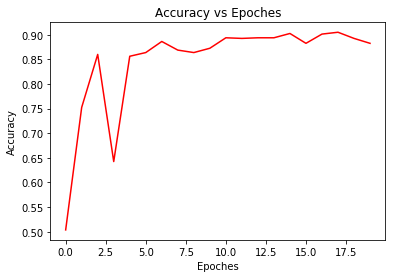

In [10]:
index = np.arange(epochs)
plt.plot(index, accuracy, 'r-')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoches")

### Test Correctness of Forward and Backward Pass

#### Forward

In [9]:
weights = np.load('weights.npz')
W0 = weights['W0']
W1 = weights['W1']
W2 = weights['W2']
print(W2.shape)
sig, _ = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
train_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])

print("train_loss:", loss(sig, val_set[1]), "train_acc:", train_acc)

(2, 1)
train_loss: [0.23266417] train_acc: 0.9175


#### Backward

In [10]:
# Make backprop testing batch
X_bp = np.vstack([train_set[0][0:8,:,:,:], train_set[0][-9:-1,:,:,:]])
Y_bp = np.vstack([train_set[1][0:8], train_set[1][-9:-1]])

# Initialize weights to all ones
# YOUR CODE HERE
W0 = np.ones_like(weights['W0'])
W1 = np.ones_like(weights['W1'])
W2 = np.ones_like(weights['W2'])
# Update weights once
# YOUR CODE HERE
sig, cache = cnn_fwd(X_bp, W0, W1, W2, mp_len)
dW0, dW1, dW2 = cnn_bwd(X_bp, Y_bp, W1, W2, mp_len, cache)
W0, W1, W2 = update(W0, W1, W2, dW0, dW1, dW2, lr)
print("W2 value:", np.sum(W2))
print("W1 value:", np.sum(W1))
print("W0 value:", np.sum(W0))

W2 value: -881.56533203125
W1 value: -499.5653320312501
W0 value: -658.5653320312501
